# Exemplo da aplicação de Deconvolução de Euler 2D para estimar a posição de diques verticais

Este [IPython Notebook](http://ipython.org/videos.html#the-ipython-notebook) utiliza a biblioteca de código aberto [Fatiando a Terra](http://fatiando.org/)

In [1]:
%matplotlib inline
import numpy as np

from fatiando import gravmag, mesher, utils, gridder
from fatiando.gravmag import prism, fourier
from fatiando.mesher import Prism, Polygon
from fatiando.utils import ang2vec, si2nt
from fatiando.gridder import regular
from fatiando.vis import mpl

Na Deconvolução de Euler 2D, as coordenadas $\color{blue}{y_{0}}$ e $\color{blue}{z_{0}}$ da fonte, bem como o nível de base $\color{green}{B}$ são estimados via solução de um sistema linear. Cada linha deste sistema linear e dada por:

$\color{blue}{y_{0}}\dfrac{\partial \Delta T_{i}}{\partial y} + 
 \color{blue}{z_{0}}\dfrac{\partial \Delta T_{i}}{\partial z} +
 \eta \, \color{green}{B} = 
 y_{i}\dfrac{\partial \Delta T_{i}}{\partial y} + 
 z_{i}\dfrac{\partial \Delta T_{i}}{\partial z} +
 \eta \, \Delta T_{i}$ ,

em que $y_{i}$ e $z_{i}$ são as coordenadas do $i$-ésimo ponto de observação, $\Delta T_{i}$, $\dfrac{\partial \Delta T_{i}}{\partial y}$ e $\dfrac{\partial \Delta T_{i}}{\partial z}$ são, respectivamente, a anomalia de campo total (ACT) e suas derivadas espaciais no $i$-ésimo ponto de observação e $\eta$ é um escalar positivo denominado **índice estrutural**. Este parâmetro define o formato da fonte cuja posição será estimada via Deconvolução de Euler.

In [2]:
def Euler2D(tf, Dytf, Dztf, y, z, si, npontos):
    '''
    Deconvolução de Euler 2D
    
    sistema de coordenadas
      x: dimensão infinita
      y: direção ao longo do perfil
      z: aponta para baixo
    
    input
      tf: array com a anomalia de campo total (ACT)
      Dytf: array com a derivada espacial da ACT na direção y
      Dztf: array com a derivada espacial da ACT na direção z
      y: array com a coordenadas das observações ao longo do perfil
      si: índice estrutural
      npontos: número de pontos em cada janela
      
    output
      y0: array com as coordenadas y estimadas para cada janela
          de dados
      z0: array com as coordenadas z estimadas para cada janela
          de dados
      b: array com os níveis de base estimados para cada janela
          de dados

    '''

    y0 = np.zeros(len(y) + 1 - npontos)
    z0 = np.zeros(len(y) + 1 - npontos)
    b = np.zeros(len(y) + 1 - npontos)
    
    vsi = si*np.ones(npontos)

    # Janela móvel
    for i in range(len(y) + 1 - npontos):
        S = np.vstack((Dytf[i:i+npontos],Dztf[i:i+npontos],vsi)).T
        s = Dytf[i:i+npontos]*y[i:i+npontos] + \
            Dztf[i:i+npontos]*z[i:i+npontos] + \
            vsi*tf[i:i+npontos]
        STS = S.T.dot(S)
        STs = S.T.dot(s)
        # Coordenadas estimadas
        p = np.linalg.solve(STS,STs)
        y0[i] = p[0]
        z0[i] = p[1]
        b[i]  = p[2]

    return y0, z0, b

## Coordenadas das observações e do modelo

In [3]:
ymin = 0.0
ymax = 100000.0
ny = 201
dy = (ymax - ymin)/(ny - 1)
L = ymax - ymin
y = np.linspace(ymin, ymax, ny)
x = np.zeros_like(y)
z = np.zeros_like(y)-150.0

zmin = -2000.0
zmax = 8000.0
xmin = -100000.0
xmax =  100000.0

area = [ymin, ymax, zmax, zmin]

incs, decs = 18.0, 10.0 # inclinação e declinação dos diques
inc, dec = -39.8, -22.5 # inclinação e declinação do campo geomagnético

## Diques sintéticos

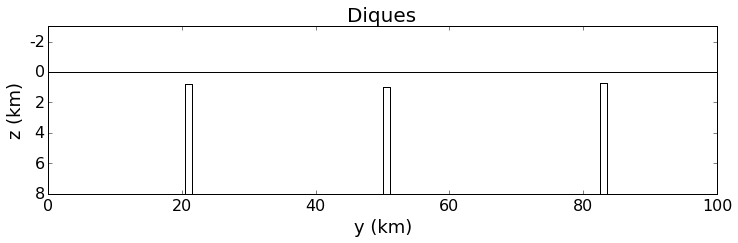

In [4]:
# Topo dos diques
d = np.array([[83000.0, 700.0],
              [50600.0, 1000.0],
              [21000.0, 800.0]])

diques = []
Ldique = 500.0
poligonos_diques = []
for i, p in enumerate(d):
    diques.append(mesher.Prism(xmin, xmax, 
                              p[0] - Ldique, p[0] + Ldique,
                              p[1], 10000, {'magnetization': utils.ang2vec(3.0, incs, decs)}))
    poligonos_diques.append(mesher.Polygon([[p[0] - Ldique, p[1]],
                                            [p[0] + Ldique, p[1]],
                                            [p[0] + Ldique, 100000],
                                            [p[0] - Ldique, 100000]]))
    

# Visualização dos diques
lambida = 0.10
mpl.figure(figsize=(12,3))
mpl.title('Diques', fontsize=20)
mpl.paths([[ymin, 0.0]], [[ymax, 0.0]], style='-k', linewidth=1)
for i, p in enumerate(poligonos_diques):
    mpl.polygon(p, style='-k', linewidth=1)
dv = lambida*(zmax - zmin)
mpl.ylim(zmax, zmin - dv)
mpl.xlim(ymin, ymax)
mpl.xlabel('y (km)', fontsize=18)
mpl.ylabel('z (km)', fontsize=18)
mpl.xticks(fontsize=16)
mpl.yticks(fontsize=16)
mpl.m2km()
mpl.show()

## Anomalia de campo total (ACT)

In [5]:
tf = gravmag.prism.tf(x, y, z, diques, inc, dec) + 30.0

## Visualização da anomalia de campo total

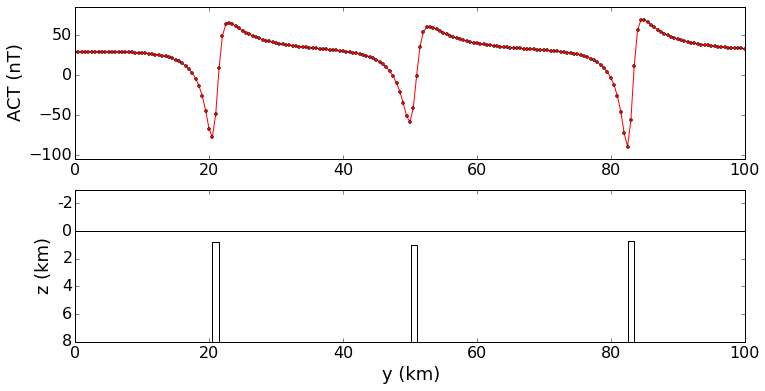

In [6]:
mpl.close('all')
mpl.figure(figsize=(12,6))

lambida = 0.10

mpl.subplot(2,1,1)
mpl.plot(0.001*y, tf, 'r-')
mpl.plot(0.001*y, tf, 'ro', markersize=3)
vmax = np.max(tf)
vmin = np.min(tf)
dv = lambida*(vmax - vmin)
mpl.ylim(vmin - dv, vmax + dv)
mpl.xlim(0.001*ymin, 0.001*ymax)
mpl.ylabel('ACT (nT)', fontsize=18)
mpl.xticks(fontsize=16)
mpl.yticks(fontsize=16)

mpl.subplot(2,1,2)
mpl.paths([[ymin, 0.0]], [[ymax, 0.0]], style='-k', linewidth=1)
for i, p in enumerate(poligonos_diques):
    mpl.polygon(p, style='-k', linewidth=1)
dv = lambida*(zmax - zmin)
mpl.ylim(zmax, zmin - dv)
mpl.xlim(ymin, ymax)
mpl.xlabel('y (km)', fontsize=18)
mpl.ylabel('z (km)', fontsize=18)
mpl.xticks(fontsize=16)
mpl.yticks(fontsize=16)
mpl.m2km()

mpl.show()

## Derivadas espaciais da ACT

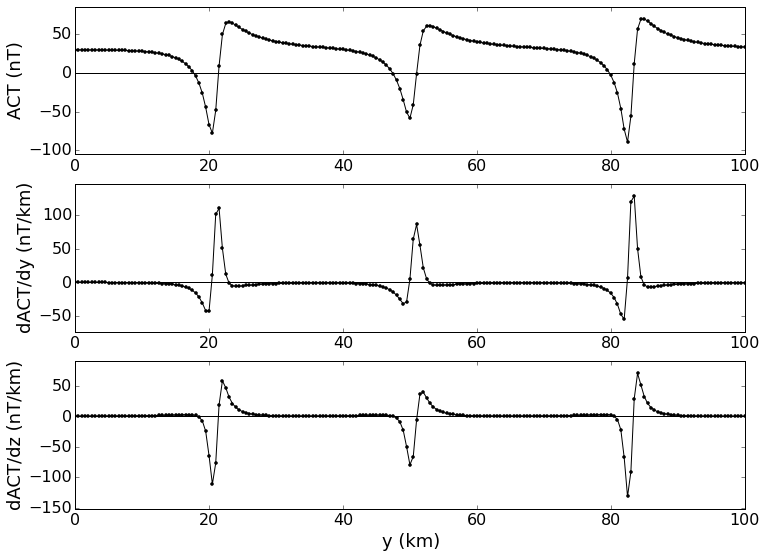

In [7]:
delta = 10.0

# Derivadas numéricas
Dytf  = gravmag.prism.tf(x, y + delta, z, diques, inc, dec)
Dytf -= gravmag.prism.tf(x, y - delta, z, diques, inc, dec)
Dytf  = Dytf/(2.0*delta) # nT/km

Dztf  = gravmag.prism.tf(x, y, z + delta, diques, inc, dec)
Dztf -= gravmag.prism.tf(x, y, z - delta, diques, inc, dec)
Dztf  = Dztf/(2.0*delta) # nT/km

# Visualização da anomalia de campo total + derivadas em y e z
mpl.close('all')
mpl.figure(figsize=(12,9))

lambida = 0.10

mpl.subplot(3,1,1)
mpl.paths([[0.001*ymin, 0.0]], [[0.001*ymax, 0.0]], style='-k', linewidth=1.0)
mpl.plot(0.001*y, tf, 'k-')
mpl.plot(0.001*y, tf, 'ko', markersize=3)
vmax = np.max(tf)
vmin = np.min(tf)
dv = lambida*(vmax - vmin)
mpl.ylim(vmin - dv, vmax + dv)
mpl.xlim(0.001*ymin, 0.001*ymax)
mpl.ylabel('ACT (nT)', fontsize=18)
mpl.xticks(fontsize=16)
mpl.yticks(fontsize=16)

mpl.subplot(3,1,2)
mpl.paths([[0.001*ymin, 0.0]], [[0.001*ymax, 0.0]], style='-k', linewidth=1.0)
mpl.plot(0.001*y, 1000.0*Dytf, 'k-')
mpl.plot(0.001*y, 1000.0*Dytf, 'ko', markersize=3)
vmax = np.max(1000.0*Dytf)
vmin = np.min(1000.0*Dytf)
dv = lambida*(vmax - vmin)
mpl.ylim(vmin - dv, vmax + dv)
mpl.xlim(0.001*ymin, 0.001*ymax)
mpl.ylabel('dACT/dy (nT/km)', fontsize=18)
mpl.xticks(fontsize=16)
mpl.yticks(fontsize=16)

mpl.subplot(3,1,3)
mpl.paths([[0.001*ymin, 0.0]], [[0.001*ymax, 0.0]], style='-k', linewidth=1.0)
mpl.plot(0.001*y, 1000.0*Dztf, 'k-')
mpl.plot(0.001*y, 1000.0*Dztf, 'ko', markersize=3)
vmax = np.max(1000.0*Dztf)
vmin = np.min(1000.0*Dztf)
dv = lambida*(vmax - vmin)
mpl.ylim(vmin - dv, vmax + dv)
mpl.xlim(0.001*ymin,0.001* ymax)
mpl.ylabel('dACT/dz (nT/km)', fontsize=18)
mpl.xlabel('y (km)', fontsize=18)
mpl.xticks(fontsize=16)
mpl.yticks(fontsize=16)

mpl.show()

## Parâmetros da Deconvolução de Euler

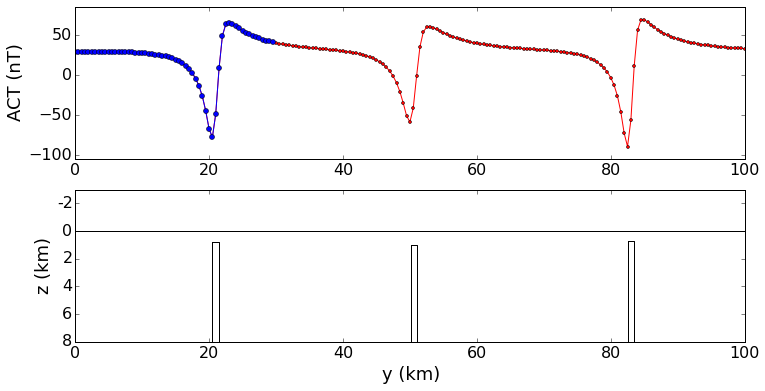

In [8]:
npontos = 60 # número de pontos por janela
#npontos = ny # apenas uma janela

dymedio = 0.5*(y[npontos-1] - y[0])

ymedio = np.linspace(ymin + dymedio, 
                     ymax - dymedio, 
                     len(y) + 1 - npontos)

n = [0.5,1,1.5,2,3] # lista de índices estruturais
colors = ['ro','go','bo','yo','ko']
labels = ['0.5','1','1.5','2','3']

mpl.close('all')
mpl.figure(figsize=(12,6))

lambida = 0.10

mpl.subplot(2,1,1)
mpl.plot(0.001*y, tf, 'r-')
mpl.plot(0.001*y, tf, 'ro', markersize=3)
mpl.plot(0.001*y[:npontos], tf[:npontos], 'b-', markersize=5)
mpl.plot(0.001*y[:npontos], tf[:npontos], 'bo', markersize=5)
vmax = np.max(tf)
vmin = np.min(tf)
dv = lambida*(vmax - vmin)
mpl.ylim(vmin - dv, vmax + dv)
mpl.xlim(0.001*ymin, 0.001*ymax)
mpl.ylabel('ACT (nT)', fontsize=18)
mpl.xticks(fontsize=16)
mpl.yticks(fontsize=16)

mpl.subplot(2,1,2)
mpl.paths([[ymin, 0.0]], [[ymax, 0.0]], style='-k', linewidth=1)
for i, p in enumerate(poligonos_diques):
    mpl.polygon(p, style='-k', linewidth=1)
dv = lambida*(zmax - zmin)
mpl.ylim(zmax, zmin - dv)
mpl.xlim(ymin, ymax)
mpl.xlabel('y (km)', fontsize=18)
mpl.ylabel('z (km)', fontsize=18)
mpl.xticks(fontsize=16)
mpl.yticks(fontsize=16)
mpl.m2km()

mpl.show()

## Deconvolução de euler

In [9]:
estimativas_y0 = []
estimativas_z0 = []
estimativas_b  = []

for j in range(len(n)):
    
    y0, z0, b = Euler2D(tf, Dytf, Dztf, y, z, n[j], npontos)
    estimativas_y0.append(y0)
    estimativas_z0.append(z0)
    estimativas_b.append(b)

## Visualização das estimativas + ACT

In [10]:
lambida = 0.10 # parâmetros que controla os eixos

### Todas juntas

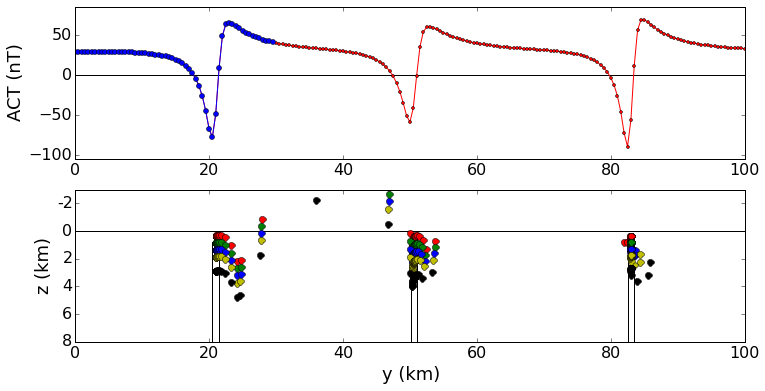

In [11]:
mpl.close('all')
mpl.figure(figsize=(12,6))

mpl.subplot(2,1,1)
mpl.paths([[0.001*ymin, 0.0]], [[0.001*ymax, 0.0]], style='-k', linewidth=1.0)
mpl.plot(0.001*y, tf, 'r-')
mpl.plot(0.001*y, tf, 'ro', markersize=3)
mpl.plot(0.001*y[:npontos], tf[:npontos], 'b-')
mpl.plot(0.001*y[:npontos], tf[:npontos], 'bo', markersize=5)
vmax = np.max(tf)
vmin = np.min(tf)
dv = lambida*(vmax - vmin)
mpl.ylim(vmin - dv, vmax + dv)
mpl.xlim(0.001*ymin, 0.001*ymax)
mpl.ylabel('ACT (nT)', fontsize=18)
mpl.xticks(fontsize=16)
mpl.yticks(fontsize=16)

mpl.subplot(2,1,2)
mpl.paths([[ymin, 0.0]], [[ymax, 0.0]], style='-k', linewidth=1)
for i, p in enumerate(poligonos_diques):
    mpl.polygon(p, style='-k', linewidth=1)
for j in range(len(n)):
    mpl.plot(estimativas_y0[j], estimativas_z0[j], colors[j], label=labels[j], markersize=7)
dv = lambida*(zmax - zmin)
mpl.ylim(zmax, zmin - dv)
mpl.xlim(ymin, ymax)
mpl.xlabel('y (km)', fontsize=18)
mpl.ylabel('z (km)', fontsize=18)
mpl.xticks(fontsize=16)
mpl.yticks(fontsize=16)
mpl.m2km()

mpl.show()

### Separadas

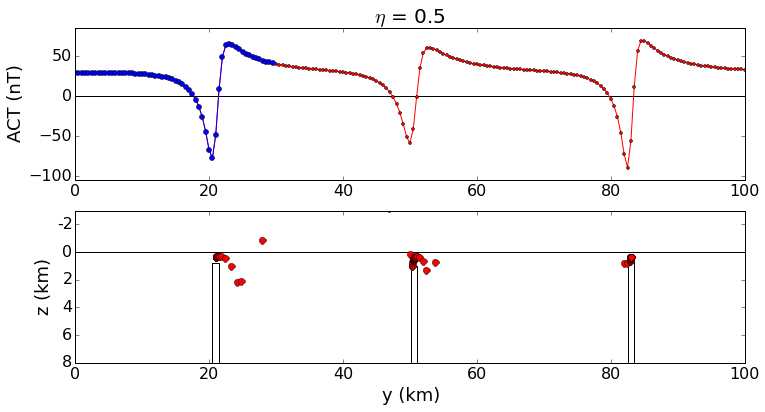

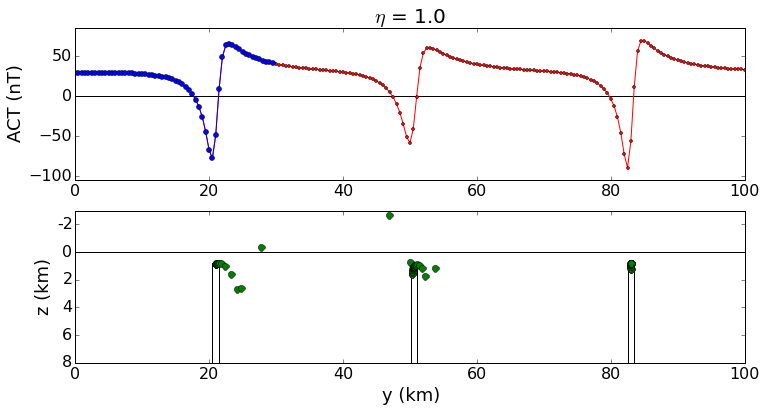

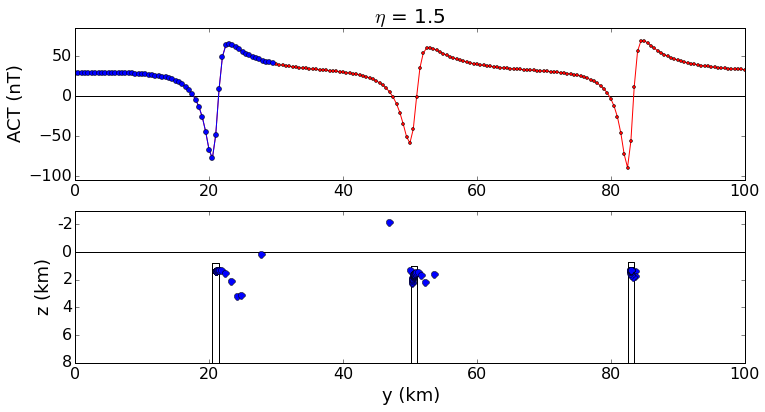

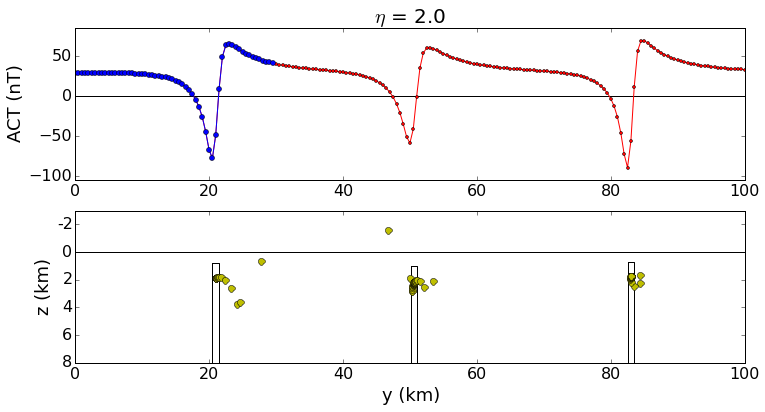

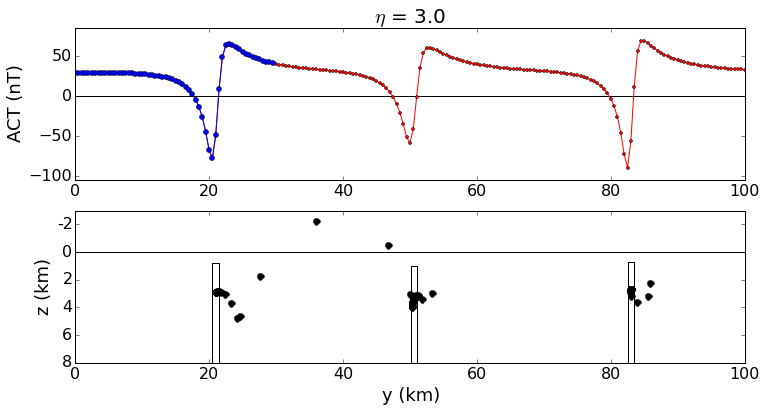

In [12]:
for j in range(len(n)):
    mpl.close('all')
    mpl.figure(figsize=(12,6))

    mpl.subplot(2,1,1)
    mpl.title('$\eta$ = %.1f' % n[j], fontsize=20)
    mpl.paths([[0.001*ymin, 0.0]], [[0.001*ymax, 0.0]], style='-k', linewidth=1.0)
    mpl.plot(0.001*y, tf, 'r-')
    mpl.plot(0.001*y, tf, 'ro', markersize=3)
    mpl.plot(0.001*y[:npontos], tf[:npontos], 'b-')
    mpl.plot(0.001*y[:npontos], tf[:npontos], 'bo', markersize=5)
    vmax = np.max(tf)
    vmin = np.min(tf)
    dv = lambida*(vmax - vmin)
    mpl.ylim(vmin - dv, vmax + dv)
    mpl.xlim(0.001*ymin, 0.001*ymax)
    mpl.ylabel('ACT (nT)', fontsize=18)
    mpl.xticks(fontsize=16)
    mpl.yticks(fontsize=16)

    mpl.subplot(2,1,2)
    mpl.paths([[ymin, 0.0]], [[ymax, 0.0]], style='-k', linewidth=1)
    for i, p in enumerate(poligonos_diques):
        mpl.polygon(p, style='-k', linewidth=1)
    mpl.plot(estimativas_y0[j], estimativas_z0[j], colors[j], label=labels[j], markersize=7)
    dv = lambida*(zmax - zmin)
    mpl.ylim(zmax, zmin - dv)
    mpl.xlim(ymin, ymax)
    mpl.xlabel('y (km)', fontsize=18)
    mpl.ylabel('z (km)', fontsize=18)
    mpl.xticks(fontsize=16)
    mpl.yticks(fontsize=16)
    mpl.m2km()

    mpl.show()

## Visualização das estimativas

In [13]:
lambida = 0.10 # parâmetros que controla os eixos

### Separadas

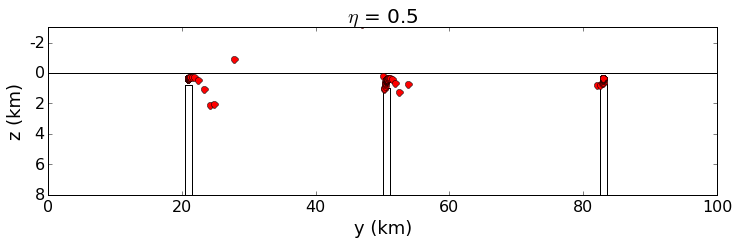

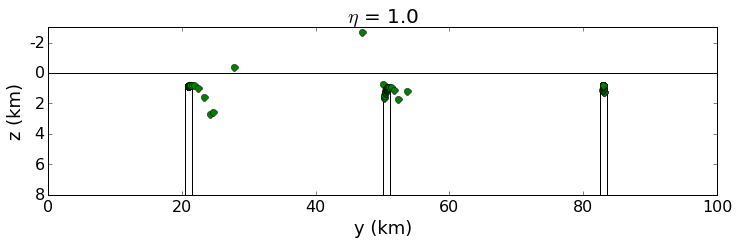

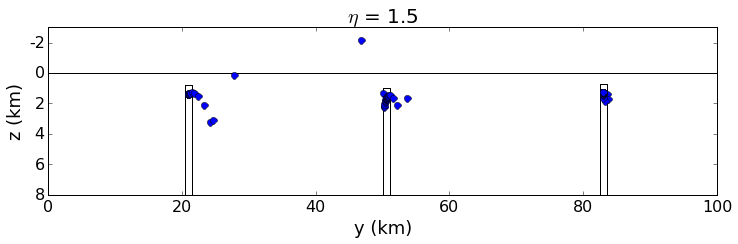

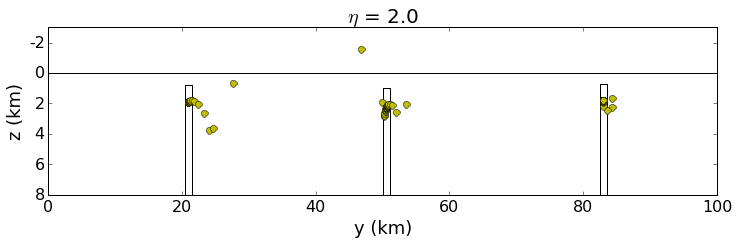

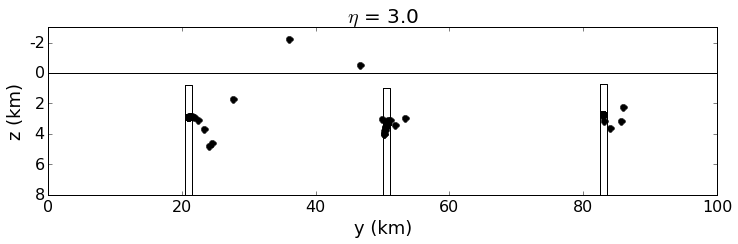

In [14]:
for j in range(len(n)):

    mpl.close('all')
    mpl.figure(figsize=(12,3))
    mpl.title('$\eta$ = %.1f' % n[j], fontsize=20)
    mpl.paths([[ymin, 0.0]], [[ymax, 0.0]], style='-k', linewidth=1)
    for i, p in enumerate(poligonos_diques):
        mpl.polygon(p, style='-k', linewidth=1)
    mpl.plot(estimativas_y0[j], estimativas_z0[j], colors[j], label=labels[j], markersize=7)
    dv = lambida*(zmax - zmin)
    mpl.ylim(zmax, zmin - dv)
    mpl.xlim(ymin, ymax)
    mpl.xlabel('y (km)', fontsize=18)
    mpl.ylabel('z (km)', fontsize=18)
    mpl.xticks(fontsize=16)
    mpl.yticks(fontsize=16)
    mpl.m2km()
    mpl.show()

### Todas juntas

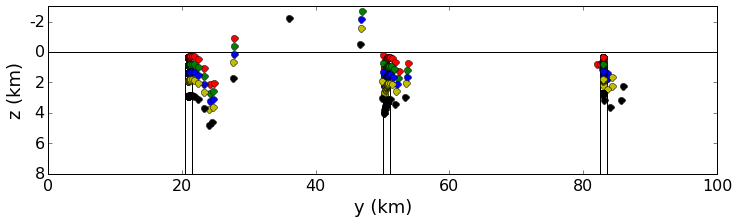

In [15]:
mpl.close('all')
mpl.figure(figsize=(12,3))
mpl.paths([[ymin, 0.0]], [[ymax, 0.0]], style='-k', linewidth=1)
for i, p in enumerate(poligonos_diques):
    mpl.polygon(p, style='-k', linewidth=1)
for j in range(len(n)):
    mpl.plot(estimativas_y0[j], estimativas_z0[j], colors[j], label=labels[j], markersize=7)
dv = lambida*(zmax - zmin)
mpl.ylim(zmax, zmin - dv)
mpl.xlim(ymin, ymax)
mpl.xlabel('y (km)', fontsize=18)
mpl.ylabel('z (km)', fontsize=18)
mpl.xticks(fontsize=16)
mpl.yticks(fontsize=16)
mpl.m2km()
mpl.show()